In [9]:
import os
import statistics
import nengo
import keras
import pandas as pd
import tensorflow as tf
import json
import nengo_dl
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, ShuffleSplit
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense
from keras import backend as K

In [10]:
dataset_path = os.path.join('..', 'datasets', 'VarekaGTNEpochs.mat') # path to dataset
os.makedirs('nengo', exist_ok=True) # make folder for param files

seed = 0 # set seed to produce same results
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
def get_dataset(file = dataset_path):
    """
    Helper function to get dataset from file.
    
    """

    np_file = loadmat(file) # load dataset file with matrices
    target_data, non_target_data = np_file['allTargetData'], np_file['allNonTargetData'] # get target and non-target data
    features = np.concatenate((target_data, non_target_data)) # concatenate target and non-target into features

    # target labels are represented as (1, 0) vector, non target labels are represented as (0, 1) vector
    target_labels = np.tile(np.array([1, 0]), (target_data.shape[0], 1)) # set 'target' as (1, 0) vector
    non_target_labels = np.tile(np.array([0, 1]), (non_target_data.shape[0], 1)) # set 'non target' as (0, 1) vector
    labels = np.vstack((target_labels, non_target_labels)) # concatenate target and non target labels

    # filter noise above 100 mV
    threshold = 100.0
    x_result, y_result = [], []
    for i in range(features.shape[0]):
        if not np.max(np.abs(features[i])) > threshold:
            x_result.append(features[i])
            y_result.append(labels[i])

    features, labels = np.array(x_result), np.array(y_result)
    features = features.reshape((features.shape[0], 1, -1))
    labels = labels.reshape((labels.shape[0], 1, -1))

    print('features:', features, features.shape)
    print('labels:', labels, labels.shape)
    return features, labels

In [12]:
def create_model():
    """
    Function to create tensorflow model
    """
    inp = Input(shape=(3, 1200, 1), name='input_layer')
    conv2d = Conv2D(filters=6, kernel_size=(3, 3), activation=tf.nn.relu)(inp)
    dropout1 = Dropout(0.5, seed=0)(conv2d)
    avg_pooling = AveragePooling2D(pool_size=(1, 8), padding='same')(dropout1)
    flatten = Flatten()(avg_pooling)
    dense1 = Dense(100, activation=tf.nn.relu)(flatten)
    batch_norm = BatchNormalization()(dense1)
    dropout2 = Dropout(0.5, seed=0)(batch_norm)
    output = Dense(2, activation=tf.nn.softmax, name='output_layer')(dropout2)

    return Model(inputs=inp, outputs=output)

In [13]:
def run_ann(model, train, valid, test, params_save_path, iteration, shuffle_training=True):
    """
    Run ann via Nengo simulator. This fits given model with training data (train) and validates it using validation
    data (valid). Then accuracy is calculated using test data (test) and weights are saved to params_save_path
    :param shuffle_training: whether to shuffle data
    :param model: tensorflow model created from create_model() function
    :param train: pair of features and labels from training data
    :param valid: pair of features and labels from validation data
    :param test: pair of features and labels from test data
    :param params_save_path: output path to save weights of the network for SNN testing
    :return accuracy on test data
    """
    x_train, y_train = train[0], train[1]
    x_valid, y_valid = valid[0], valid[1]
    x_test, y_test = test[0], test[1]

    converter = nengo_dl.Converter(model)
    with nengo_dl.Simulator(converter.net, minibatch_size=16) as simulator:
        # some data will get truncated due to batch size
        simulator.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
        )

        input_layer = converter.inputs[model.get_layer('input_layer')] # get nengo input
        output_layer = converter.outputs[model.get_layer('output_layer')] # get nengo output

        simulator.fit(
            x={ input_layer: x_train }, y={ output_layer: y_train },
            validation_data=({ input_layer: x_valid }, { output_layer: y_valid }),
            epochs=30,
            shuffle=shuffle_training,
            callbacks=[EarlyStopping(patience=5, verbose=1, restore_best_weights=True)] # early stop to avoid overfitting
        ) # train model

        simulator.save_params(params_save_path) # save params for SNN
        ann_eval = simulator.evaluate(x={ input_layer: x_test }, y={ output_layer: y_test }) # evaluate accuracy
        print('{}. ann accuracy: {:5f}%'.format(iteration, ann_eval['probe_accuracy'] * 100)) # log accuracy
        return ann_eval['probe_accuracy'] # return accuracy

def run_snn(model, test, params_load_path, timesteps, scale_firing_rates, synapse, iteration):
    """
    Runs SNN on test data. Loads pre-trained weights from params_load path and uses timesteps, scale_firing_rates and synapse
    parameters for simulator.
    :param model:
    :param test:
    :param params_load_path:
    :param timesteps:
    :param scale_firing_rates:
    :param synapse:
    :param iteration:
    :return: accuracy on predicted data
    """
    converter = nengo_dl.Converter(
        model=model,
        swap_activations={ tf.nn.relu: nengo.SpikingRectifiedLinear() },
        scale_firing_rates=scale_firing_rates,
        synapse=synapse
    )

    x_test, y_test = test[0], test[1]

    with converter.net:
        nengo_dl.configure_settings(stateful=False)

    input_layer = converter.inputs[model.get_layer('input_layer')] # input layer for simulator
    output_layer = converter.outputs[model.get_layer('output_layer')] # output layer for simulator

    x_test_time_tiled = np.tile(x_test, (1, timesteps, 1)) # tile x_test to match desired timesteps for simulator

    with nengo_dl.Simulator(converter.net, minibatch_size=41, progress_bar=False) as simulator:
        simulator.load_params(params_load_path)

        predictions = simulator.predict({ input_layer: x_test_time_tiled })[output_layer] # get results from prediction
        predictions = predictions[:,-1,:] # get last timestep

        predictions = np.argmax(predictions, axis=-1) # get argmax
        y_test = np.squeeze(y_test, axis=1) # remove time dimension from labels since its not relevant
        y_test = np.argmax(y_test, axis=-1) # get argmax of y test as well for comparison

        snn_avg = (predictions == y_test).mean()

        if synapse is None:
            print('{}. snn [timesteps={}, scale_firing_rates={}, synapse=None], accuracy: {:4f}%'
                .format(iteration, timesteps, scale_firing_rates, snn_avg*100))
        else:
            print('{}. snn [timesteps={}, scale_firing_rates={}, synapse={:5f}], accuracy: {:4f}%'
                .format(iteration, timesteps, scale_firing_rates, synapse, snn_avg*100))

        return snn_avg

In [14]:
features, labels = get_dataset()
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.25, random_state=seed, shuffle=True)

print('train_x: {}, shape: {}, train_y: {}, shape: {}'.format(x_train, x_train.shape, y_train, y_train.shape))
print('test_x: {}, shape: {}, test_y: {}, shape: {}'.format(x_test, x_test.shape, y_test, y_test.shape))

ann, snn = [], []

# 'hyper-parameters' with format: timesteps, scale_firing_rates, synapse
snn_config = [
    [30, 1000, 0.01], # best performing parameters for simulator
    [30, 1, 0.01], # spike scaling fire rates are set to 1 == off
    [30, 1000, None], # synaptic smoothing turned off
    [30, 1, None] # everything turned off, only RELU is swapped for spiking RELU
]

n_iterations = 30 # iterations of cross-valiation
iteration = 1 # number of current iteration
monte_carlo = ShuffleSplit(n_splits=n_iterations, test_size=.25, random_state=seed)
for train, valid in monte_carlo.split(x_train):
    print('Iteration: {}'.format(iteration)) # Print number of iteration

    x_train_current, y_train_current = x_train[train], y_train[train] # get training data for current iteration
    x_valid_current, y_valid_current = x_train[valid], y_train[valid] # get validation data for current iteration

    params_path = os.path.join('nengo', 'params_iter_{}'.format(iteration)) # path to weights for current iteration

    model = create_model() # create model

    # run ann
    ann_result = run_ann(model=model,
                         train=(x_train_current, y_train_current),
                         valid=(x_valid_current, y_valid_current),
                         test=(x_test, y_test),
                         params_save_path=params_path,
                         iteration=iteration
                         )
    K.clear_session() # clear session
    ann.append(ann_result)

    # run spiking network for each combination of timesteps, spike scaling and synapse and append it to the snn_results
    snn_results = []
    for variant in snn_config:
        snn_acc = run_snn(model=model,
                          test=(x_test, y_test),
                          params_load_path=params_path,
                          timesteps=variant[0],
                          scale_firing_rates=variant[1],
                          synapse=variant[2],
                          iteration=iteration
                          )
        K.clear_session() # clear session not to cause a memory leak
        snn_results.append(snn_acc)

    del model # delete model to avoid potential memory leak (this might be unnecessary)
    iteration += 1
    # append list of accuracies for each parameter variant to the snn list
    snn.append(snn_results)

14. snn [timesteps=30, scale_firing_rates=1, synapse=None], accuracy: 52.663016%
features: [[[ -0.77055806  -0.76216829  -0.75329262 ...   0.9730792    1.04828787
     1.00901747]]

 [[  4.72857332   4.79228735   4.86664867 ... -15.98517323 -16.30454826
   -16.64167595]]

 [[ -2.2145133   -1.49968874  -0.77021754 ...  -6.05920124  -5.69483948
    -5.42987347]]

 ...

 [[  9.08650398   9.06958485   9.0740099  ...  18.27712059  17.41079521
    16.49032021]]

 [[  3.50287008   2.95584893   2.36093497 ...  20.93103218  21.30741882
    21.62874603]]

 [[-14.8089571  -14.57761955 -14.33197689 ...  32.55890274  32.86030197
    33.12610626]]] (8036, 1, 3600)
labels: [[[1 0]]

 [[1 0]]

 [[1 0]]

 ...

 [[0 1]]

 [[0 1]]

 [[0 1]]] (8036, 1, 2)
train_x: [[[ -0.5420959   -1.21452522  -1.89456093 ...  -1.16598654  -1.73066759
    -2.2462945 ]]

 [[ -9.35857487  -9.43084145  -9.40663052 ...  -1.80052102  -0.70815951
     0.17630903]]

 [[  4.39046383   3.40499306   2.36262703 ...  38.03783417  38.

KeyboardInterrupt: 

In [15]:
def save_stats(ann, snn, snn_config, snn_config_output, xlsx_output, average_accs_output):
    """
    Save statistics to excel file. These were further used in p300-nengo-visualization notebook
    :param ann: accuracies of ann network
    :param snn: accuracies of snn network
    :param snn_config: list of configurations for snn
    :param snn_config_output: name of json file where configs for snn will be saved
    :param xlsx_output: name of output file
    :param average_accs_output: name of file containing average accuracy and std
    """

    snn_config_array = []
    for variant in snn_config:
        snn_config_array.append({
            'timesteps': variant[0],
            'scale_firing_rates': variant[1],
            'synapse': variant[2] if variant[2] is not None else 'None'
        })

    with open(snn_config_output, 'w') as file:
        json.dump(snn_config_array, file)

    data = {
        'iterations': [x for x in range(1, len(ann) + 1)],
        'ann_accuracy': ann,
    } # data dictionary for pandas dataframe

    variants = [] # create key for data dictionary for each configuration of snn
    for variant in snn_config:
        # synapse can be None which is cannot be passed as format parameter for some reason
        if variant[2] is None:
            variants.append('snn [timesteps={}, scaling={}, synapse=None]'
                            .format(variant[0], int(variant[1])))
        else:
            variants.append('snn [timesteps={}, scaling={}, synapse={:3f}]'
                        .format(variant[0], int(variant[1]), variant[2]))

    # split accuracies for each configuration to specific list
    # meaning each accuracy with configuration "A" will be in list on index a ...
    snn_accs_by_variant = [[] for _ in range(len(variants))]
    for snn_acc_list in snn:
        for i in range(len(snn_acc_list)):
            snn_accs_by_variant[i].append(snn_acc_list[i])

    # add accuracies for each snn configuration to the dataset
    for i in range(len(variants)):
        data[variants[i]] = snn_accs_by_variant[i]

    # create dataframe, print it and save as excel spreadsheet
    df = pd.DataFrame(data=data, index=list(range(1, len(ann) + 1)))
    print(df)
    df.to_excel(xlsx_output)

    # create dataframe for average accuracies and their sample standard deviations

    data_stats = {
        'model': ['ANN'] + variants,
        'average_accuracy': [],
        'sample_standard_deviation': []
    }

    data_stats['average_accuracy'].append(statistics.mean(ann))
    data_stats['sample_standard_deviation'].append(statistics.stdev(ann))

    for snn_acc in snn_accs_by_variant:
        data_stats['average_accuracy'].append(statistics.mean(snn_acc))
        data_stats['sample_standard_deviation'].append(statistics.stdev(snn_acc))
    
    df_stats = pd.DataFrame(data=data_stats) # create dataframe for stats
    df_stats.to_excel(average_accs_output, index=False) # save to excel

    #
    # # create graph. Graph will be 130% of default size to ensure readability since it contains a lot of data
    # df.plot(x='iterations', y=['ann_accuracy'] + variants, kind='bar', title='Accuracy of ANN and respective variant of SNN per iteration',
    #         figsize=[6.4 * 3, 4.8 * 3], width=0.9)
    # plt.yticks(np.arange(0, 1.0, 0.05))
    # plt.xticks(rotation=0)
    # plt.ylabel('Accuracy')
    # plt.xlabel('Iterations')
    # # plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    # plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.05), ncol=3,
    #         borderaxespad=0, frameon=False)
    # plt.savefig(graph_output, format=graph_format, bbox_inches='tight')
    # plt.show()

    iterations  ann_accuracy  \
1            1        0.6290   
2            2        0.6445   
3            3        0.6380   
4            4        0.6345   
5            5        0.6355   
6            6        0.6430   
7            7        0.6395   
8            8        0.6430   
9            9        0.6410   
10          10        0.6500   
11          11        0.6360   
12          12        0.6420   
13          13        0.6415   
14          14        0.6580   
15          15        0.6365   
16          16        0.6335   
17          17        0.6360   
18          18        0.6415   
19          19        0.6425   
20          20        0.6420   
21          21        0.6325   
22          22        0.6490   
23          23        0.6330   
24          24        0.6400   
25          25        0.6450   
26          26        0.6365   
27          27        0.6470   
28          28        0.6420   
29          29        0.6280   
30          30        0.6395   

    snn

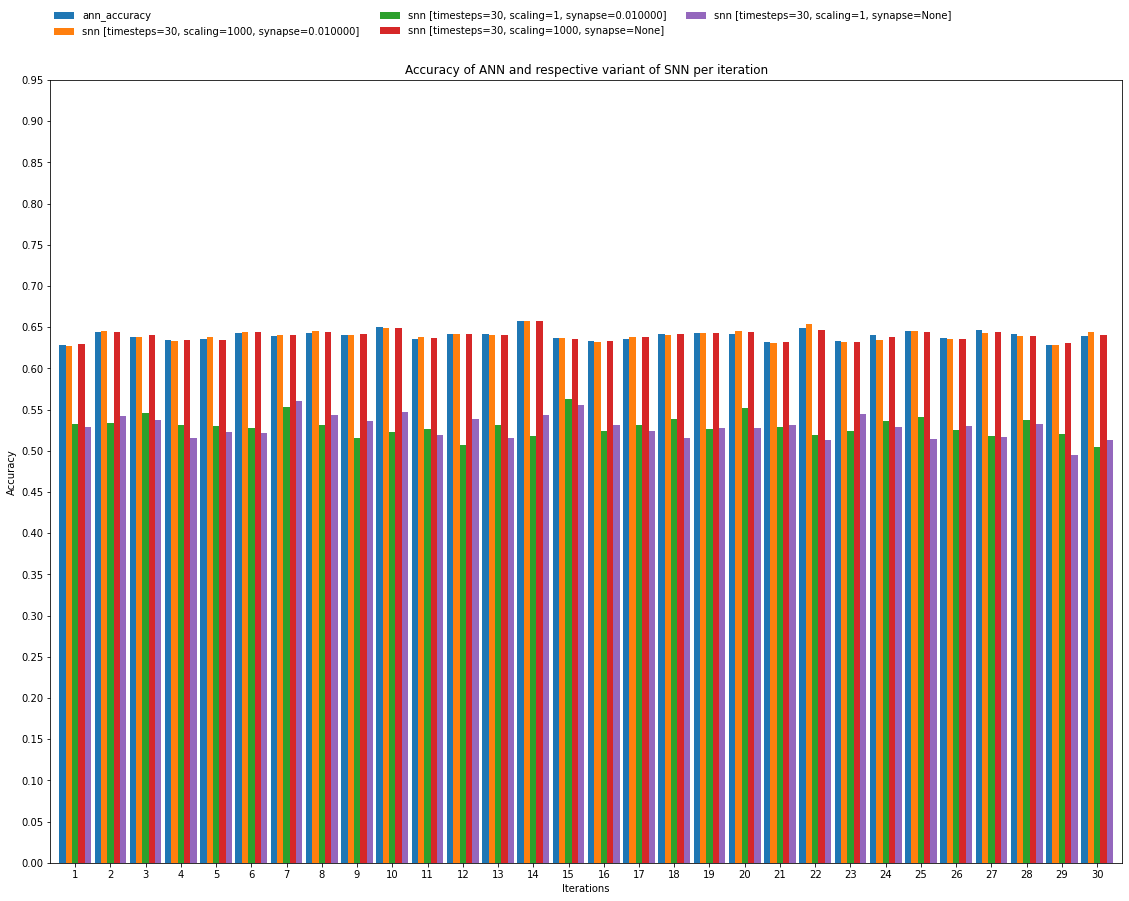

In [16]:
save_stats(ann=ann,
          snn=snn,
          snn_config=snn_config,
          xlsx_output=os.path.join('output', 'values.xlsx'),
          average_accs_output=os.path.join('output','accs.xlsx'),
          graph_output=os.path.join('output', 'graph.svg')
)


